# Mixture of Compound Gaussians 

Compound Gaussian is a more general class of distributions that can be expressed as

$$X = \mu + \sqrt{\tau} A g$$

with $\tau \geq 0$ random variable, $g\sim \mathcal{N}(0, I)$, $AA^T=\Sigma$ 

$X_i|\tau=\tau_i \sim \mathcal{N}(\mu_j,\tau_i \Sigma_j)$

We load the libraries

In [1]:
import numpy as np
import random 
import pandas as pd
import os
import time
import csv 
import warnings

# MATH and STATS:
import math
from scipy.stats import t
from scipy.stats import multivariate_normal
from scipy.special import gamma

# PLOT:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D # 3D
from plotnine import *
from plotnine.data import *
%matplotlib inline

# SKLEARN:
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.manifold import TSNE
import sklearn.datasets
from sklearn import metrics # AMII and ARI
from sklearn import decomposition #PCA

import umap

In [2]:
from frem import *
from import_subset_datasets import *

In [3]:
warnings.filterwarnings('ignore')

## Experiments

### Normal

DATA: 2 gaussian p=10


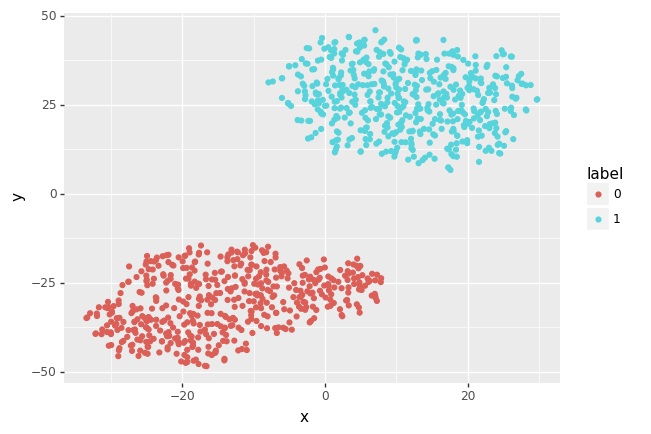

<ggplot: (-9223371883721634693)>

In [14]:
np.random.seed(66)
K = 2
p = 10
n = 1000
p_noise = 0

#############################################
means = [[0]*p, [2]*p]
means = [np.random.random((p, )), 2* np.random.random((p, ))+ np.random.random((p, ))+1.3] 
#sigmas = [np.diag([0.25, 1.75]), np.eye(p)]
sigmas = [np.diag([0.25, 3.5, 0.25, 0.75,1.5,0.5,1,0.25, 1, 1]) , np.eye(p)]
#sigmas = [np.diag([2, 0.25, 0.75]) , np.eye(p)]

############################################

alpha = np.random.random_sample((K,))
alpha /= np.sum(alpha)
data_x_normal = np.empty((n, p))
labels = []

for i in range(n):
    cluster = int(np.random.choice(range(K), 1))
    labels.append(cluster)
    mean = means[cluster]
    sigma = sigmas[cluster] 
    data_x_normal[i, :] = np.random.multivariate_normal(mean, sigma)
    
if p>2:
    data_x_embedded_normal = TSNE(n_components=2).fit_transform(data_x_normal)
    dataset_x_normal = pd.DataFrame(data_x_embedded_normal, columns=['x', 'y'])   
else:
    dataset_x_normal = pd.DataFrame(data_x_normal, columns=['x', 'y'])  
    
dataset_x_normal['label'] = pd.Series(np.array(labels).astype('str'))
print("DATA: 2 gaussian p=10")
ggplot(dataset_x_normal, aes(x='x',y='y',color='label'))+geom_point()

In [15]:
print('AMI: ', metrics.adjusted_mutual_info_score(np.array(labels).astype('str'), kmeans.labels_.astype(str)))

AMI:  0.6588205767792714


In [9]:
resultado = FREM(2, data_x_normal, 250, False, 1, 15) 

convergence:  True
number of iterations:  7


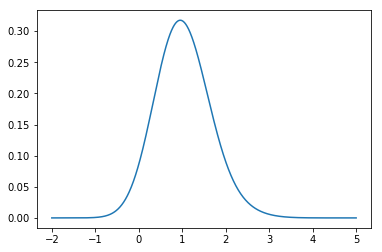

In [8]:
xxx = resultado[0]['tau'][:, 1][:, np.newaxis]
X_plot = np.linspace(-2, 5, 1000)[:, np.newaxis]
kde = KernelDensity(bandwidth=0.45).fit(xxx)
log_dens = kde.score_samples(X_plot)
plt.plot(X_plot[:, 0], np.exp(log_dens))
plt.show()

### CG-EM:

In [10]:
theta_estimated_1, cond_prob_1, delta_mu_1, delta_sigma_1 = FREM(2, data_x_normal, 150, False, 1, 30)  
theta_estimated_2, cond_prob_2, delta_mu_2, delta_sigma_2 = FREM(2, data_x_normal, 150, False, 2, 30)
theta_estimated_3, cond_prob_3, delta_mu_3, delta_sigma_3 = FREM(2, data_x_normal, 150, False, 3, 30)
theta_estimated_4, cond_prob_4, delta_mu_4, delta_sigma_4 = FREM(2, data_x_normal, 150, False, 4, 30)

convergence:  True
number of iterations:  7
convergence:  True
number of iterations:  7
convergence:  True
number of iterations:  7
convergence:  True
number of iterations:  7


Check results:

In [48]:
theta_estimated = resultado[0]

In [35]:
print("CHECKING RESULTS:")
print("trace Sigma 0: ", np.trace(theta_estimated['Sigma'][1]))
print("trace Sigma 1: ", np.trace(theta_estimated['Sigma'][0]))
print("mu 0:", theta_estimated['mu'][0])
print("mu 1:", theta_estimated['mu'][1])
print("Avg error sigma 0:", np.linalg.norm(theta_estimated['Sigma'][0]-sigmas[1], ord='fro')/(p*p))
print("Avg error sigma 1:", np.linalg.norm(theta_estimated['Sigma'][1]-sigmas[0], ord='fro')/(p*p))

CHECKING RESULTS:
trace Sigma 0:  2.0
trace Sigma 1:  2.0
mu 0: [2.13542296 2.88768635]
mu 1: [0.13201033 0.03117572]
Avg error sigma 0: 0.035805992254853536
Avg error sigma 1: 0.05713862469298841


In [36]:
gmm = GaussianMixture(n_components=2)
gmm.fit(data_x_normal)
labels_gmm = gmm.predict(data_x_normal)

In [37]:
print("error mu 0:", np.linalg.norm(gmm.means_[0]-means[1]))
print("error mu 1:", np.linalg.norm(gmm.means_[1]-means[0]))
print("Avg error sigma 0:", np.linalg.norm(gmm.covariances_[0]/np.trace(gmm.covariances_[0])*p-sigmas[0], ord='fro')/(p*p))
print("Avg error sigma 1:", np.linalg.norm(gmm.covariances_[1]/np.trace(gmm.covariances_[1])*p-sigmas[1], ord='fro')/(p*p))


error mu 0: 3.429264559176627
error mu 1: 3.5202914599006383
Avg error sigma 0: 0.010563449294022701
Avg error sigma 1: 0.019845794893272907


Plot embedding with clustering labels

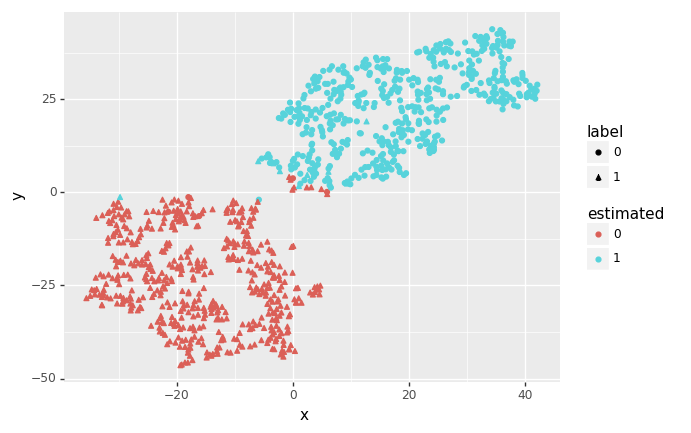

<ggplot: (-9223371950395386999)>

In [29]:
cond_prob = resultado[1]
labels_cg = [str(i) for i in np.argmax(cond_prob, axis=1)]
dataset_x_normal['estimated'] = pd.Series(labels_cg)
ggplot(dataset_x_normal, aes(x='x',y='y',color='estimated', shape='label'))+geom_point()

Check fixed-point convergence

Error during fixed-point iteration for $\mu$ with the 4 different versions:

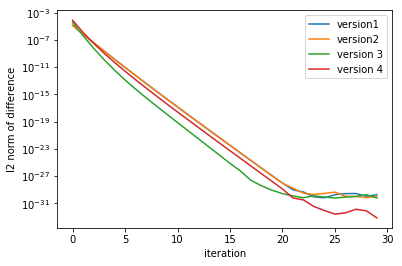

In [13]:
#rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
## for Palatino and other serif fonts use:
#rc('font',**{'family':'serif','serif':['Palatino']})
import matplotlib as mpl
mpl.rc('text', usetex = False)
plt.semilogy(delta_mu_1[1][0, :])
plt.semilogy(delta_mu_2[1][0, :])
plt.semilogy(delta_mu_3[1][0, :])
plt.semilogy(delta_mu_4[1][0, :])
plt.legend(('version1', 'version2', 'version 3', 'version 4'))
plt.xlabel('iteration')
plt.ylabel('l2 norm of difference')
plt.show()

Error during fixed-point iteration for $\Sigma$ with the 4 different versions:

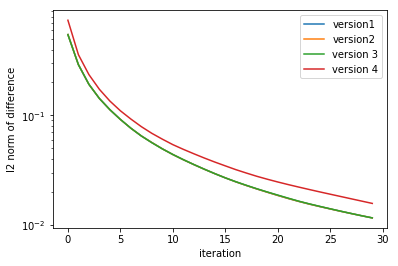

In [11]:
plt.semilogy(delta_sigma_1[1][0, :])
plt.semilogy(delta_sigma_2[1][0, :])
plt.semilogy(delta_sigma_3[1][0, :])
plt.semilogy(delta_sigma_4[1][0, :])
plt.legend(('version1', 'version2', 'version 3', 'version 4'))
plt.xlabel('iteration')
plt.ylabel('l2 norm of difference')
plt.show()

In [19]:
print('AMI: ', metrics.adjusted_mutual_info_score(np.array(labels).astype('str'), labels_cg))
print('ARI: ', metrics.adjusted_rand_score(np.array(labels).astype('str'), labels_cg))
print('acc: ', max([np.sum(labels_cg == np.array(labels).astype('str'))/len(np.array(labels).astype('str')), np.sum(labels_cg !=np.array(labels).astype('str'))/len(np.array(labels).astype('str'))]))

AMI:  0.7383984383439905
ARI:  0.8279278446547436
acc:  0.955


### Dimension = 10, 3 student t

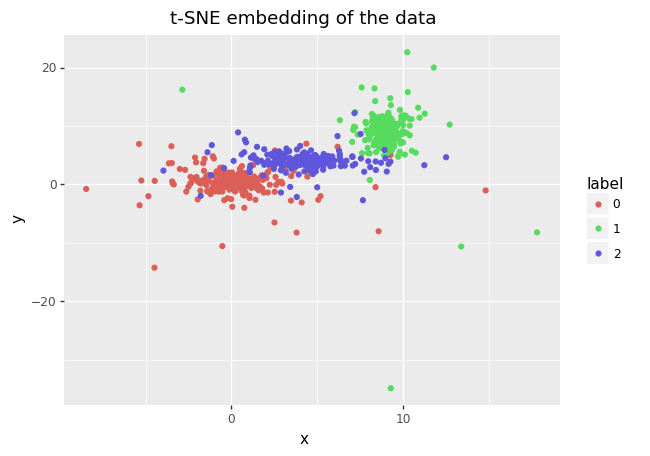

<ggplot: (125218522986)>
tau mean: 4.6926421607574405


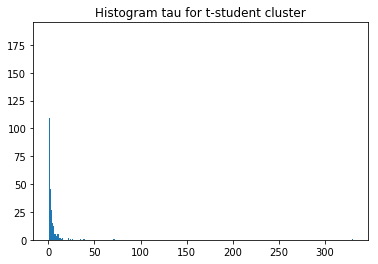

In [10]:
np.random.seed(66)
K = 3
p = 2
n = 800
p_noise = 0
dof = 2.3
#############################################
np.random.random()
#means = [np.random.random((p, )), [2.5]*p, (np.array([0]*p) + np.array([2]*p))/2+np.array((3, 0, 0, 0, 0, 0, 0 , 0, 0, 0))] 
means = [np.random.random((p, )), [9]*p, (np.array([0]*p) + np.array([3]*p))+1]

#sigmas = [np.diag([3, 2, 0.25, 0.75,1,0.5,1,0.5, 0.5, 0.5]), np.diag([0.5, 4, 0.25, 0.25,1.5,0.5, 1, 0.5, 0.5, 1]), np.eye(p)]
sigmas = [np.eye(p), np.diag([0.25, 1.75]), np.diag([1.5, 0.5])]
############################################

alpha = [1.0/3.0, 1.0/3.0, 1.0/3.0]
data_x = np.empty((n, p))
labels = []
tau_for_t = []

# Data generation 
for i in range(n):
    cluster = int(np.random.choice(range(K), 1))
    labels.append(cluster)
    mean = means[cluster]
    sigma = sigmas[cluster] 
    if True:
        tau = 1/np.random.gamma(dof/2, 2/dof)
        #tau = np.random.pareto(2.0005, 1) + 1
        tau_for_t.append(tau)
        data_x[i, :] = means[cluster] + np.sqrt(tau)*np.random.multivariate_normal([0]*p, sigma)
    else:
        data_x[i, :] = np.random.multivariate_normal(mean, sigma)

# t-SNE:
if p>2:
    data_x_embedded = TSNE(n_components=2).fit_transform(data_x)
    dataset_x = pd.DataFrame(data_x_embedded, columns=['x', 'y'])   
else:
    dataset_x = pd.DataFrame(data_x, columns=['x', 'y'])  

# PLOTS:
dataset_x['label'] = pd.Series(np.array(labels).astype('str'))
print(ggplot(dataset_x, aes(x='x',y='y',color='label'))+geom_point()+ggtitle('t-SNE embedding of the data'))

print('tau mean:', np.array(tau_for_t).mean())
plt.hist(tau_for_t, bins='auto')  
plt.title("Histogram tau for t-student cluster")
plt.show()

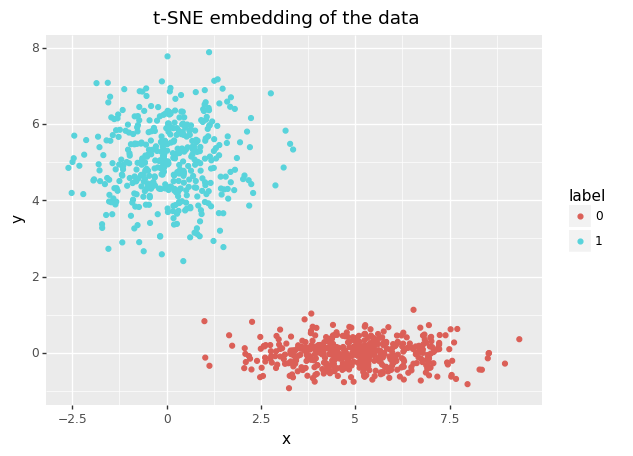

<ggplot: (125218515755)>


In [9]:
np.random.seed(99)
K = 2
p = 2
n = 900
p_noise = 0
dof = 2.5

#############################################
means = [np.array([5, 0]), np.array([0, 5])] 

sigmas = [np.array([[1.9, 0],[0, 0.1]]), np.eye(p)]
############################################

alpha = [1.0/2.0, 1.0/2.0]
data_x = np.empty((n, p))
labels = []
tau_for_t = []

# Data generation 
for i in range(n):
    cluster = int(np.random.choice(range(K), 1))
    labels.append(cluster)
    mean = means[cluster]
    sigma = sigmas[cluster] 
    if False:
        #tau = 1/np.random.gamma(dof/2, 2/dof)
        #tau = np.random.pareto(2.0005, 1) + 1
        #tau_for_t.append(tau)
        data_x[i, :] = means[cluster] + np.sqrt(tau)*np.random.multivariate_normal([0]*p, sigma)
    else:
        data_x[i, :] = np.random.multivariate_normal(mean, sigma)

# t-SNE:
if p>2:
    data_x_embedded = TSNE(n_components=2).fit_transform(data_x)
    dataset_x = pd.DataFrame(data_x_embedded, columns=['x', 'y'])   
else:
    dataset_x = pd.DataFrame(data_x, columns=['x', 'y'])  

# PLOTS:
dataset_x['label'] = pd.Series(np.array(labels).astype('str'))
print(ggplot(dataset_x, aes(x='x',y='y',color='label'))+geom_point()+ggtitle('t-SNE embedding of the data'))

In [151]:
p = 2
sigma1 = np.array([[1.9, 0],[0, 0.1]])
sigma2 = np.eye(p)
mu1  = np.array([5, 0])
mu2  = np.array([0, 5])
test = np.array([5, 5])
tau1 = ((test-mu1).T @ np.linalg.inv(sigma1) @ (test-mu1))/p
tau2 = ((test-mu1).T @ np.linalg.inv(sigma2) @ (test-mu1))/p
pnormal1 = multivariate_normal(mean = mu1, cov = tau1 * sigma1)
print(pnormal1.pdf(test))
pnormal2 = multivariate_normal(mean = mu2, cov = tau2 * sigma2)
print(pnormal2.pdf(test))


0.0010745802053719546
0.004683986521945533


In [ ]:
np.random.seed(99)
K = 2
p = 2
n = 800
p_noise = 0
dof = 2.5

#############################################
np.random.random()
means = [[0]*p, [2]*p, (np.array([0]*p) + np.array([2]*p))/2 + 1 + np.random.random((p, ))] 

sigmas = [np.diag([3, 2, 0.25, 0.75,1,0.5,1,0.5, 0.5, 0.5]), np.diag([0.5, 4, 0.25, 0.25,1.5,0.5, 1, 0.5, 0.5, 1]), np.eye(p)]
############################################

alpha = [1.0/3.0, 1.0/3.0, 1.0/3.0]
data_x = np.empty((n, p))
labels = []
tau_for_t = []

# Data generation 
for i in range(n):
    cluster = int(np.random.choice(range(K), 1))
    labels.append(cluster)
    mean = means[cluster]
    sigma = sigmas[cluster] 
    if True:
        #tau = 1/np.random.gamma(dof/2, 2/dof)
        tau = np.random.pareto(2.0005, 1) + 1
        tau_for_t.append(tau)
        data_x[i, :] = means[cluster] + np.sqrt(tau)*np.random.multivariate_normal([0]*p, sigma)
    else:
        data_x[i, :] = np.random.multivariate_normal(mean, sigma)

# t-SNE:
if p>2:
    data_x_embedded = TSNE(n_components=2).fit_transform(data_x)
    dataset_x = pd.DataFrame(data_x_embedded, columns=['x', 'y'])   
else:
    dataset_x = pd.DataFrame(data_x, columns=['x', 'y'])  

# PLOTS:
dataset_x['label'] = pd.Series(np.array(labels).astype('str'))
print(ggplot(dataset_x, aes(x='x',y='y',color='label'))+geom_point()+ggtitle('t-SNE embedding of the data'))

print('tau mean:', np.array(tau_for_t).mean())
plt.hist(tau_for_t, bins='auto')  
plt.title("Histogram tau for t-student cluster")
plt.show()

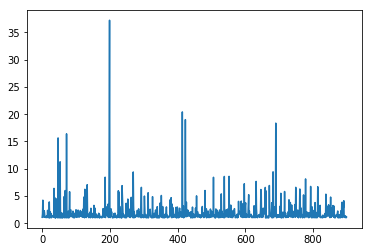

In [74]:
plt.plot(tau_for_t)
plt.show()

In [44]:
theta_estimated_1, cond_prob, delta_mu, delta_sigma = FREM(3, data_x, 100, False, 1, 15)

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
convergence:  True
number of iterations:  17


In [117]:
np.savetxt("simulacion_tres_paretos.csv", data_x, delimiter=",")

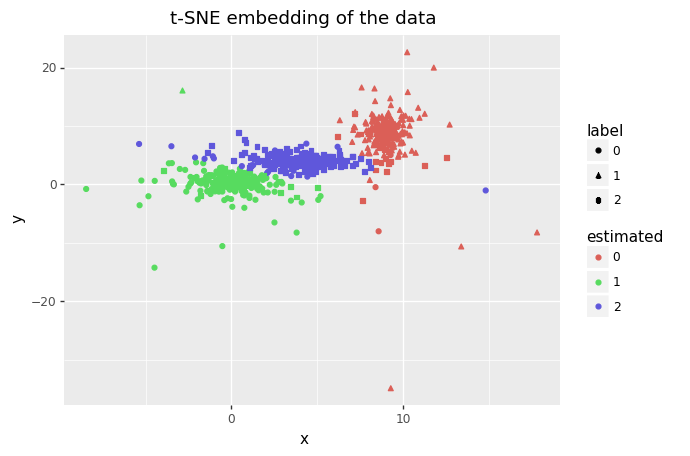

<ggplot: (86461624205)>


In [45]:
# Plots:
#cond_prob = compute_condition_prob_matrix(data_x, theta_estimated_1)
labels_cg = [str(i) for i in np.argmax(cond_prob, axis=1)]
dataset_x['estimated'] = pd.Series(labels_cg)
print(ggplot(dataset_x, aes(x='x',y='y',color='estimated', shape='label'))+geom_point()+ggtitle('t-SNE embedding of the data'))

In [46]:
print('AMI: ', metrics.adjusted_mutual_info_score(labels_cg, labels))
print('ARI: ', metrics.adjusted_rand_score(labels_cg, labels))

AMI:  0.7759722014702396
ARI:  0.8251316460158933


mean: 1.9543370800265


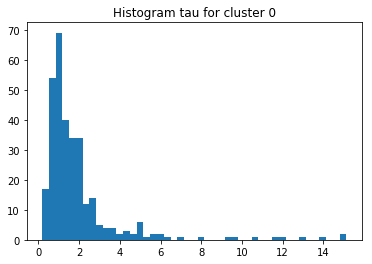

In [68]:
index_0 = (np.argmax(cond_prob, 1) == 0)
tau_0 = theta_estimated_1['tau'][index_0, 0]
print('mean:', tau_0.mean())
plt.hist(tau_0, bins='auto')  # arguments are passed to np.histogram
plt.title("Histogram tau for cluster 0")
plt.show()

mean: 2.1294709239277876


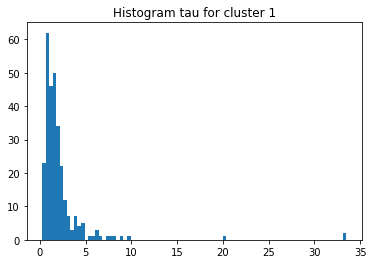

In [70]:
index_1 = (np.argmax(cond_prob, 1) == 1)
tau_1 = theta_estimated_1['tau'][index_1, 1]
print('mean:', tau_1.mean())
plt.hist(tau_1, bins='auto')  # arguments are passed to np.histogram
plt.title("Histogram tau for cluster 1")
plt.show()

mean: 2.0461724722217767


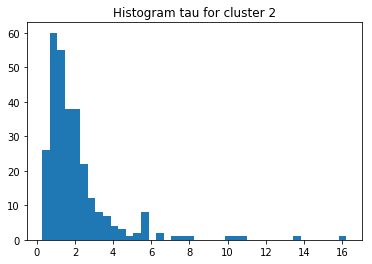

In [71]:
index_2 = (np.argmax(cond_prob, 1) == 2)
tau_2 = theta_estimated_1['tau'][index_2, 2]
print('mean:', tau_2.mean())
plt.hist(tau_2, bins='auto')  # arguments are passed to np.histogram
plt.title("Histogram tau for cluster 2")
plt.show()

#### Comparison with usual GMM-EM

In [47]:
gmm = GaussianMixture(n_components=3)
gmm.fit(data_x)
labels_gmm = gmm.predict(data_x)

print('AMI: ', metrics.adjusted_mutual_info_score(labels_gmm, labels))
print('ARI: ', metrics.adjusted_rand_score(labels_gmm, labels))

AMI:  0.7480365528015532
ARI:  0.7862845217451461


#### Comparison with usual kmeans

C:\Users\roizmanv\anaconda3\lib\site-packages\sklearn\metrics\cluster\supervised.py:732: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)


AMI:  0.487275166685266
ARI:  0.4729087882458594


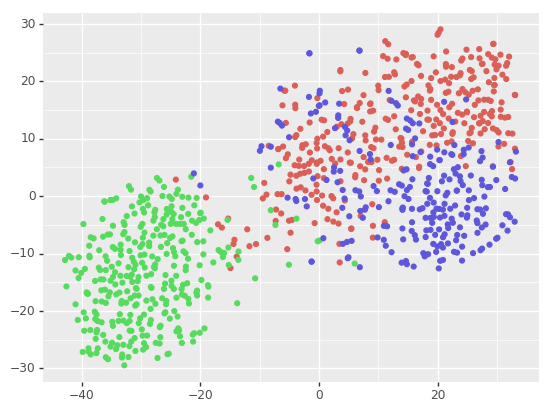

<ggplot: (109793407864)>

In [127]:
kmeans = KMeans(n_clusters=3).fit(data_x)
dataset_x['kmeans'] = pd.Series(kmeans.labels_.astype(str))
print('AMI: ', metrics.adjusted_mutual_info_score(kmeans.labels_.astype(str), labels))
print('ARI: ', metrics.adjusted_rand_score(kmeans.labels_.astype(str), labels))
ggplot(dataset_x, aes(x='x',y='y',color='kmeans'))+geom_point()+ scale_color_discrete(guide=False)+ylab("")+xlab("")

In [129]:
rlabels = pd.read_csv("est_labels_simulacion_pareto_2.csv").values[:,1]
print(rlabels)
print('AMI: ', metrics.adjusted_mutual_info_score(labels, rlabels))
print('ARI: ', metrics.adjusted_rand_score(labels, rlabels))

[3 1 1 3 1 2 1 1 1 1 1 2 1 1 3 3 3 1 1 3 2 3 3 2 1 3 3 1 2 2 3 1 1 1 3 1 1
 2 2 1 1 2 2 1 1 3 1 3 3 2 2 1 3 1 1 1 1 3 1 3 3 3 2 3 3 3 1 2 3 2 1 1 3 3
 3 2 3 2 1 1 2 2 1 2 3 1 3 3 1 2 1 2 3 3 3 2 2 1 1 3 1 2 3 3 2 1 2 3 2 3 1
 2 1 1 3 2 1 1 3 3 1 1 3 1 3 2 1 3 2 1 1 3 1 3 3 3 1 3 3 3 3 1 2 3 3 1 2 3
 3 1 2 3 1 2 2 2 1 2 2 1 3 1 1 1 2 3 3 1 1 1 3 2 1 1 2 2 3 1 3 1 3 3 3 1 2
 2 3 1 2 3 3 3 2 3 3 3 2 3 1 1 3 1 3 2 2 2 1 2 2 2 2 3 2 1 3 1 3 3 3 2 1 2
 1 1 2 1 3 3 3 2 3 2 3 1 2 2 2 2 1 2 1 2 3 3 1 2 1 1 1 3 1 3 1 3 2 1 1 2 1
 2 1 1 1 2 1 1 3 2 2 1 1 3 1 1 3 1 3 2 3 2 1 1 3 3 1 1 3 2 3 1 1 1 2 1 1 1
 3 3 1 3 3 1 3 3 2 2 1 1 3 3 3 1 2 3 2 1 3 3 2 1 1 3 1 1 3 2 1 1 2 1 2 3 1
 3 1 2 1 3 3 2 3 1 2 2 3 2 1 1 2 2 1 3 2 3 2 2 1 2 1 1 3 3 3 2 3 3 2 2 1 1
 1 2 1 1 3 3 3 1 2 2 1 3 3 3 3 3 3 1 1 3 3 1 3 1 3 2 3 3 3 3 2 2 3 1 1 3 3
 1 3 3 1 1 3 2 3 1 3 3 2 3 2 1 1 3 3 2 1 2 3 2 3 3 3 3 3 3 1 3 1 2 3 3 1 3
 1 3 1 1 1 2 1 2 1 1 2 3 1 2 1 1 2 3 1 2 1 2 3 2 2 1 3 3 3 1 1 2 2 2 1 1 2
 1 2 2 2 2 3 3 1 2 3 2 1 

C:\Users\roizmanv\anaconda3\lib\site-packages\sklearn\metrics\cluster\supervised.py:732: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)


In [128]:
np.savetxt("simulacion_tres_paretos_2.csv", data_x, delimiter=",")

## Simulation for tables

hola


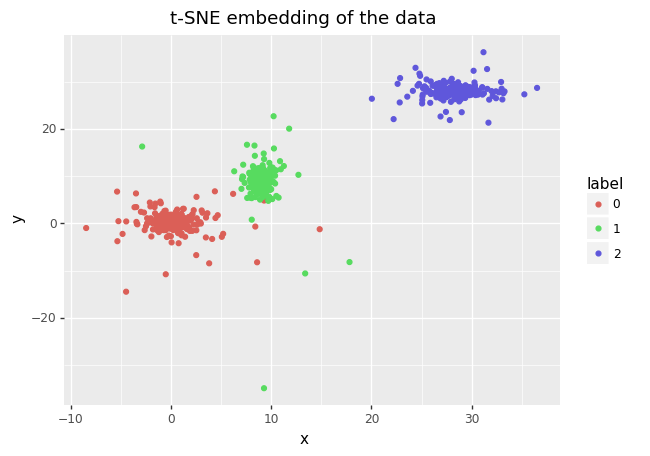

<ggplot: (125219829245)>
convergence:  True
number of iterations:  8


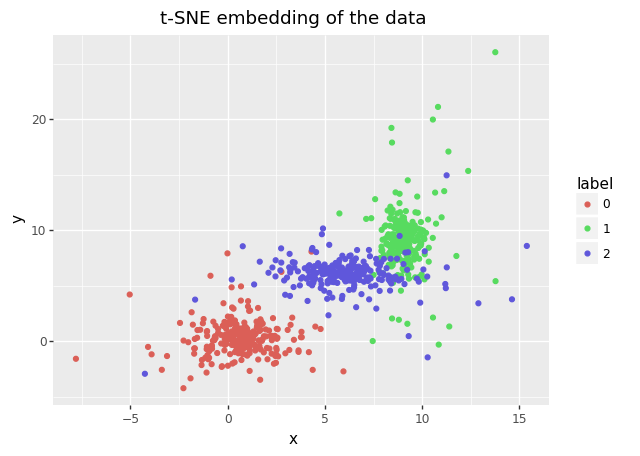

<ggplot: (125218374215)>
convergence:  True
number of iterations:  14


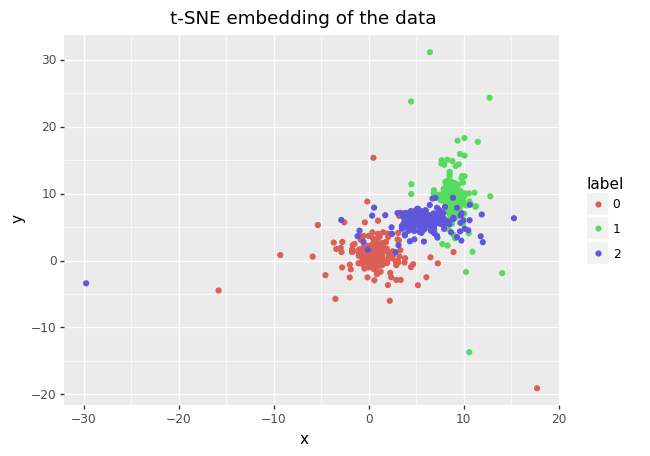

<ggplot: (-9223371911635093581)>
convergence:  True
number of iterations:  16


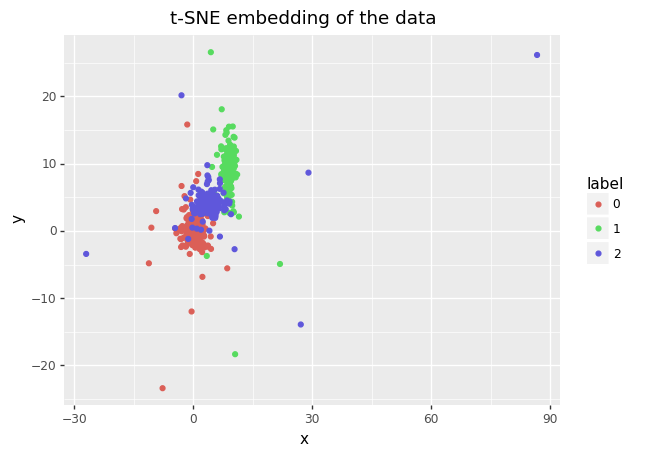

<ggplot: (-9223371911634903962)>
convergence:  True
number of iterations:  22


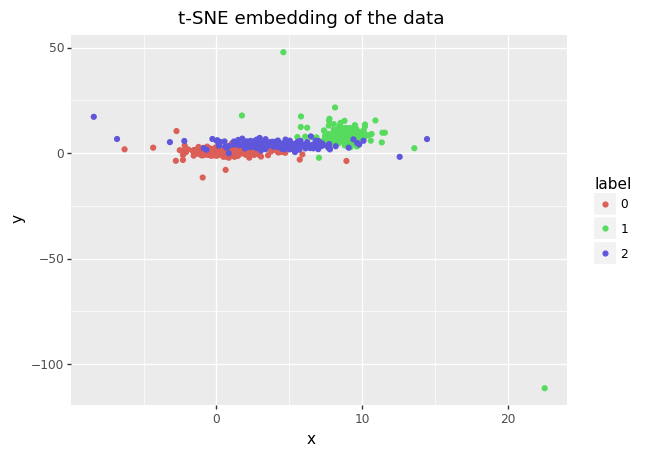

<ggplot: (-9223371911635173267)>
singular matix


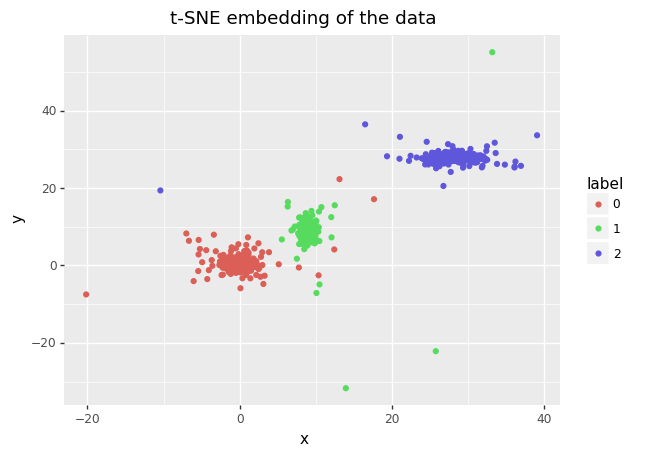

<ggplot: (-9223371911634968218)>
convergence:  True
number of iterations:  8


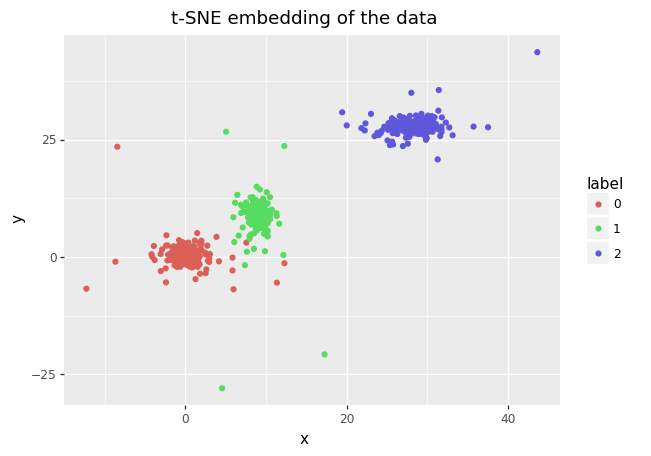

<ggplot: (125218365886)>
convergence:  True
number of iterations:  7


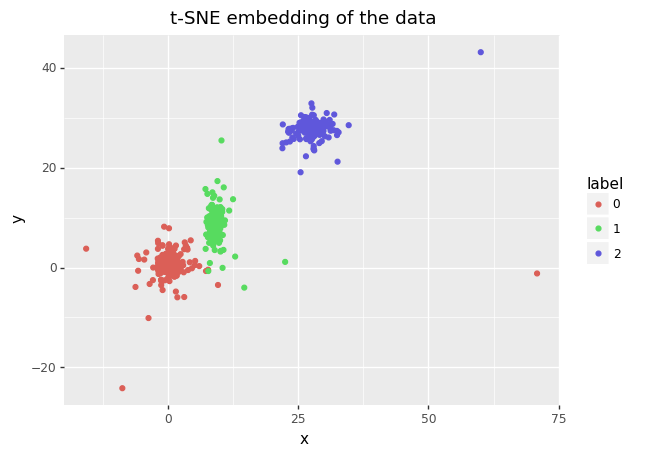

<ggplot: (125219807608)>
convergence:  True
number of iterations:  8


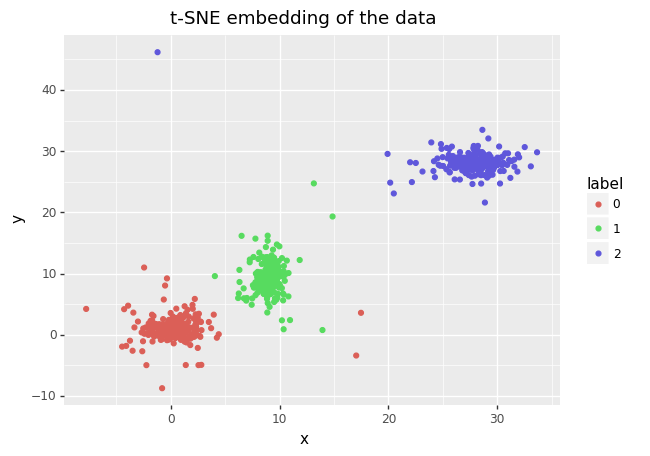

<ggplot: (125220188343)>
convergence:  True
number of iterations:  8


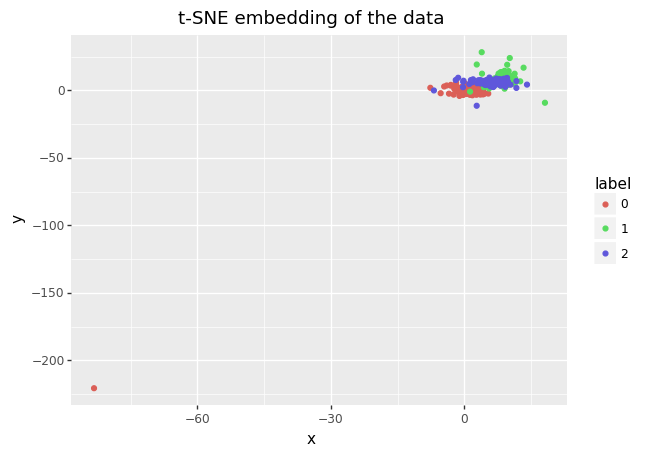

<ggplot: (-9223371911634612308)>
singular matix


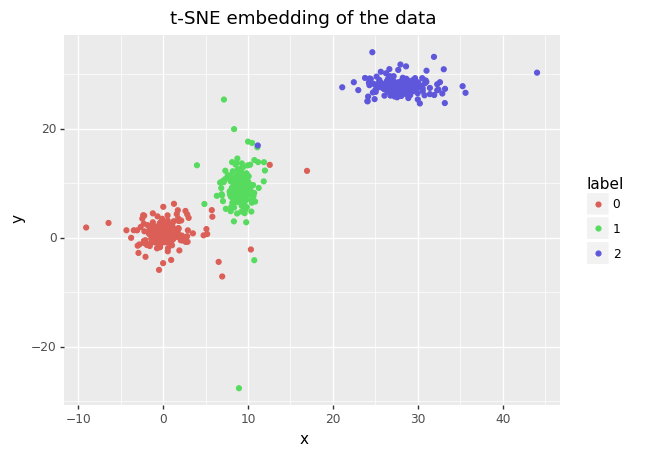

<ggplot: (-9223371911635177156)>
convergence:  True
number of iterations:  8


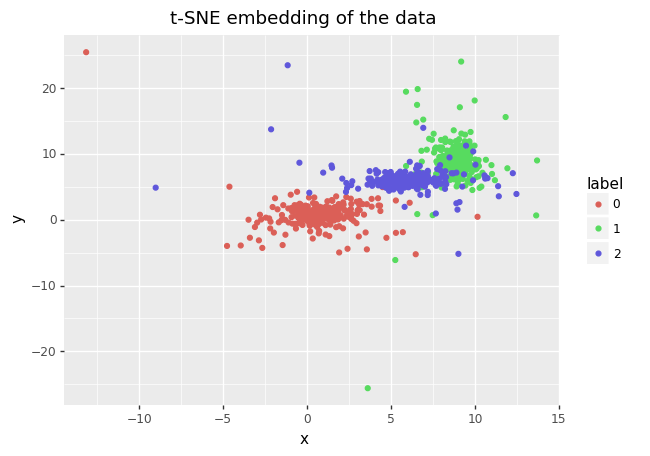

<ggplot: (125218410020)>
convergence:  True
number of iterations:  16


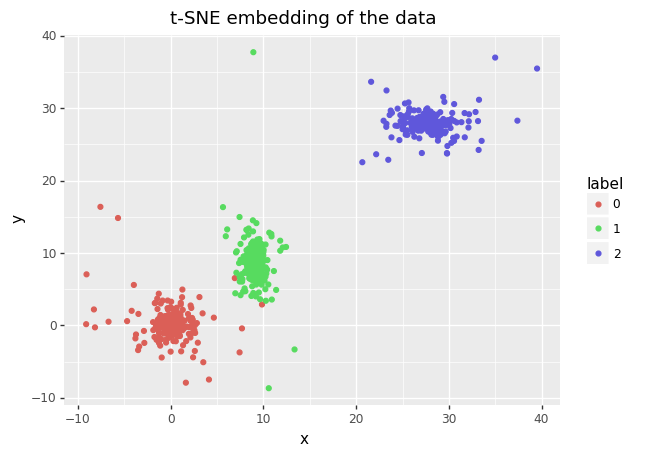

<ggplot: (-9223371911635146173)>
convergence:  True
number of iterations:  7


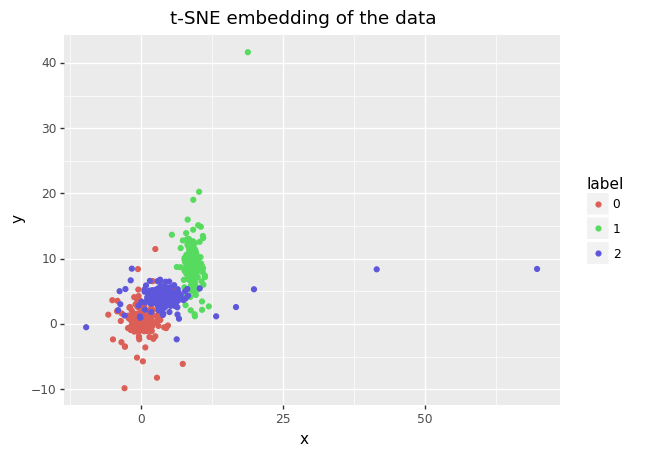

<ggplot: (125219694344)>
singular matix


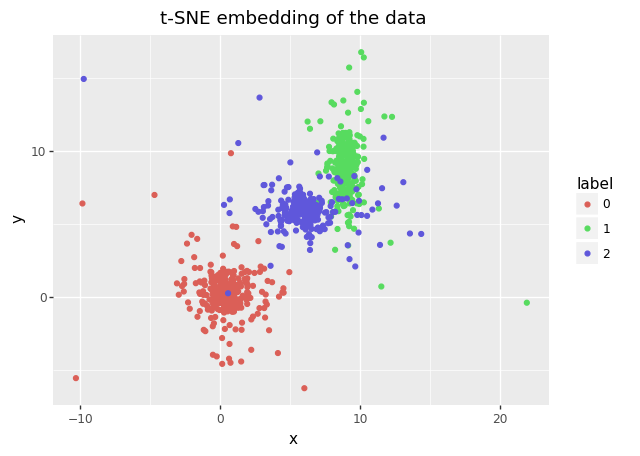

<ggplot: (125219647594)>
convergence:  True
number of iterations:  14


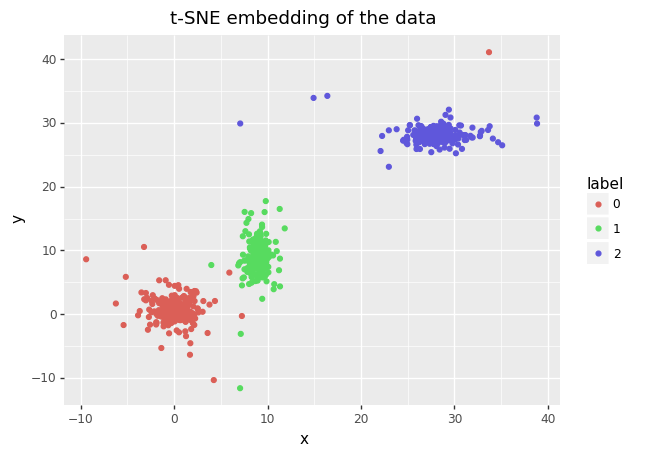

<ggplot: (-9223371911633378602)>
convergence:  True
number of iterations:  7


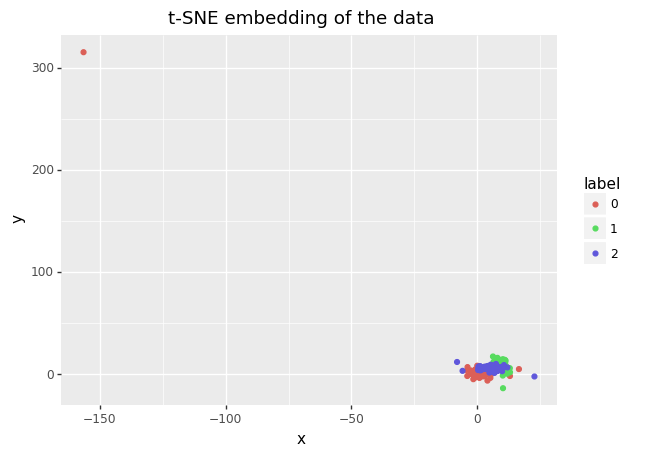

<ggplot: (125221467491)>
convergence:  True
number of iterations:  28


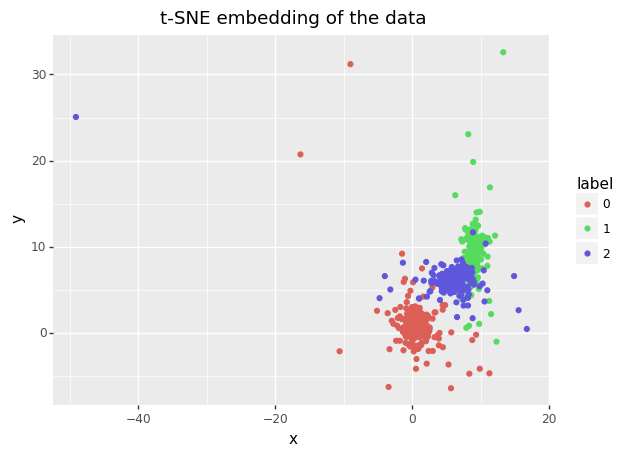

<ggplot: (-9223371911635047073)>
convergence:  True
number of iterations:  29


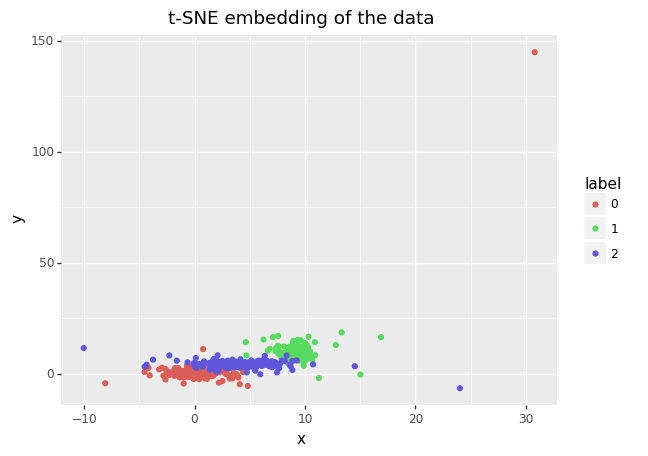

<ggplot: (125221972323)>
singular matix


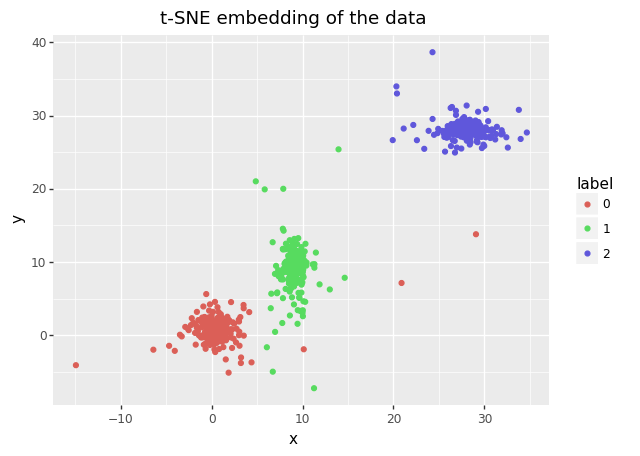

<ggplot: (125218474865)>
convergence:  True
number of iterations:  8


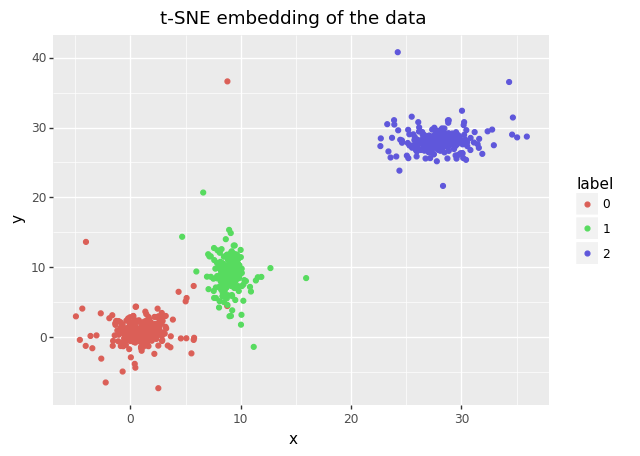

<ggplot: (-9223371911633374867)>
convergence:  True
number of iterations:  8


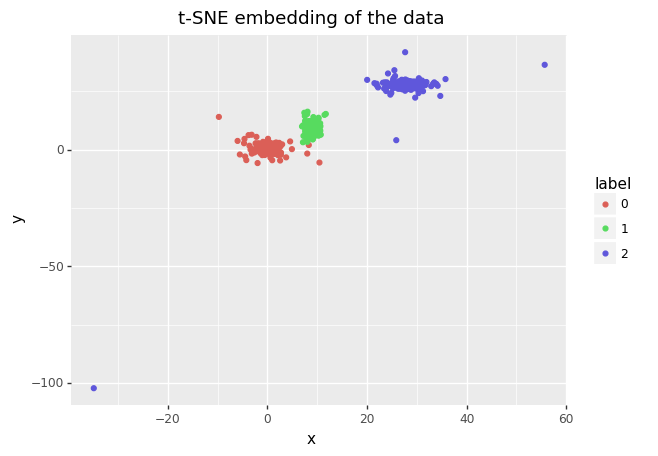

<ggplot: (-9223371911634975267)>
convergence:  True
number of iterations:  7


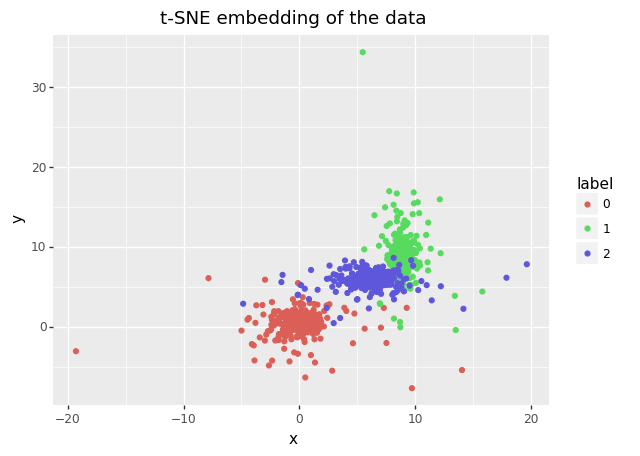

<ggplot: (125221400917)>
convergence:  True
number of iterations:  15


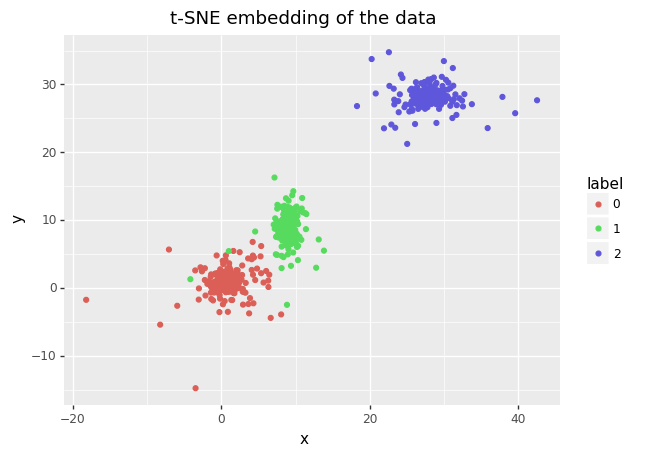

<ggplot: (125219891937)>
convergence:  True
number of iterations:  8


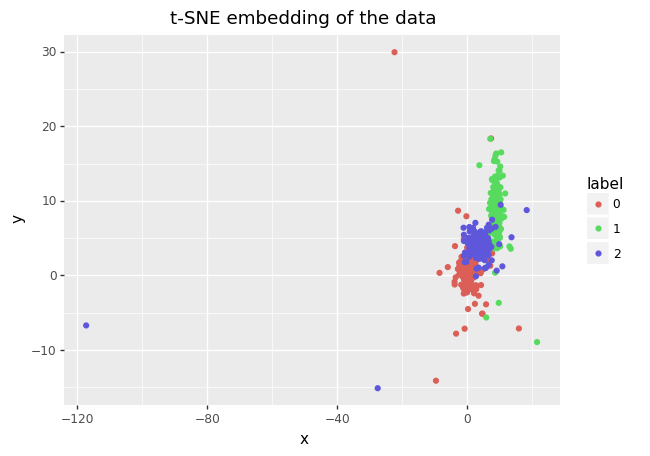

<ggplot: (125218515783)>
convergence:  True
number of iterations:  20


In [18]:
AMI_cg = []
ARI_gmm = []
ARI_cg = []
AMI_gmm = []
errores_sigma_cg = []
errores_sigma_gmm = []
errores_mu_gmm = []
errores_mu_cg = []
np.random.seed(66)

K = 3
p = 2
n = 800
p_noise = 0
dof = 2.3
print("hola")
for ite_ in range(25):
    
    try:
        

        #############################################
        #means = [np.random.random((p, )), [2.5]*p, (np.array([0]*p) + np.array([2]*p))/2+np.array((3, 0, 0, 0, 0, 0, 0 , 0, 0, 0))] 
        means = [np.random.random((p, )), [9]*p, (np.array([0]*p) + np.array([3]*p))+np.random.choice([1, 3, 25])]

        #sigmas = [np.diag([3, 2, 0.25, 0.75,1,0.5,1,0.5, 0.5, 0.5]), np.diag([0.5, 4, 0.25, 0.25,1.5,0.5, 1, 0.5, 0.5, 1]), np.eye(p)]
        sigmas = [np.eye(p), np.diag([0.25, 1.75]), np.diag([1.5, 0.5])]
        ############################################

        alpha = [1.0/3.0, 1.0/3.0, 1.0/3.0]
        data_x = np.empty((n, p))
        labels = []
        tau_for_t = []

        # Data generation 
        for i in range(n):
            cluster = int(np.random.choice(range(K), 1))
            labels.append(cluster)
            mean = means[cluster]
            sigma = sigmas[cluster] 
            if True:
                tau = 1/np.random.gamma(dof/2, 2/dof)
                #tau = np.random.pareto(2.0005, 1) + 1
                tau_for_t.append(tau)
                data_x[i, :] = means[cluster] + np.sqrt(tau)*np.random.multivariate_normal([0]*p, sigma)
            else:
                data_x[i, :] = np.random.multivariate_normal(mean, sigma)

        # t-SNE:
        if p>2:
            data_x_embedded = TSNE(n_components=2).fit_transform(data_x)
            dataset_x = pd.DataFrame(data_x_embedded, columns=['x', 'y'])   
        else:
            dataset_x = pd.DataFrame(data_x, columns=['x', 'y'])  

        # PLOTS:
        dataset_x['label'] = pd.Series(np.array(labels).astype('str'))
        print(ggplot(dataset_x, aes(x='x',y='y',color='label'))+geom_point()+ggtitle('t-SNE embedding of the data'))

        theta_estimated, cond_prob, delta_mu, delta_sigma = FREM(3, data_x, 40, False, 1, 30)
 
        np.savetxt("data_x"+str(ite_)+".csv", data_x, delimiter=",") # to run in R
        np.savetxt("labels_x"+str(ite_)+".csv", labels, delimiter=",") # to run in R
        cond_prob = compute_condition_prob_matrix(data_x, theta_estimated)
        labels_cg = [str(iii) for iii in np.argmax(cond_prob, axis=1)]
        AMI_cg.append(metrics.adjusted_mutual_info_score(labels_cg, labels))
        ARI_cg.append(metrics.adjusted_rand_score(labels_cg, labels))
        gmm = GaussianMixture(n_components=3)
        gmm.fit(data_x)
        labels_gmm = gmm.predict(data_x)
        AMI_gmm.append(metrics.adjusted_mutual_info_score(labels_gmm, labels))
        ARI_gmm.append(metrics.adjusted_rand_score(labels_gmm, labels))
        error1 = np.min([np.linalg.norm(theta_estimated['Sigma'][0]-sigmas[0], ord='fro')/(p*p),
                        np.linalg.norm(theta_estimated['Sigma'][0]-sigmas[1], ord='fro')/(p*p), 
                        np.linalg.norm(theta_estimated['Sigma'][0]-sigmas[2], ord='fro')/(p*p)])
        error2 = np.min([np.linalg.norm(theta_estimated['Sigma'][1]-sigmas[0], ord='fro')/(p*p),
                        np.linalg.norm(theta_estimated['Sigma'][1]-sigmas[1], ord='fro')/(p*p), 
                        np.linalg.norm(theta_estimated['Sigma'][1]-sigmas[2], ord='fro')/(p*p)])
        error3 = np.min([np.linalg.norm(theta_estimated['Sigma'][2]-sigmas[0], ord='fro')/(p*p),
                        np.linalg.norm(theta_estimated['Sigma'][2]-sigmas[1], ord='fro')/(p*p), 
                        np.linalg.norm(theta_estimated['Sigma'][2]-sigmas[2], ord='fro')/(p*p)])
        sigmaa = (error1 + error2 + error3)/3
        errores_sigma_cg.append(sigmaa)
        errormu1 = min(np.linalg.norm(theta_estimated['mu'][0]-means[0]), np.linalg.norm(theta_estimated['mu'][0]-means[1]), np.linalg.norm(theta_estimated['mu'][0]-means[2])) 
        errormu2 = min(np.linalg.norm(theta_estimated['mu'][1]-means[0]), np.linalg.norm(theta_estimated['mu'][1]-means[1]), np.linalg.norm(theta_estimated['mu'][1]-means[2])) 
        errormu3 = min(np.linalg.norm(theta_estimated['mu'][2]-means[0]), np.linalg.norm(theta_estimated['mu'][2]-means[1]), np.linalg.norm(theta_estimated['mu'][2]-means[2])) 
        muu = (errormu1 + errormu2 + errormu3)/3
        errores_mu_cg.append(muu)
        error1 = min(np.linalg.norm(gmm.covariances_[0]-sigmas[0], ord='fro')/(p*p),
                        np.linalg.norm(gmm.covariances_[0]-sigmas[1], ord='fro')/(p*p), 
                        np.linalg.norm(gmm.covariances_[0]-sigmas[2], ord='fro')/(p*p))
        error2 = min(np.linalg.norm(gmm.covariances_[1]-sigmas[0], ord='fro')/(p*p),
                        np.linalg.norm(gmm.covariances_[1]-sigmas[1], ord='fro')/(p*p), 
                        np.linalg.norm(gmm.covariances_[1]-sigmas[2], ord='fro')/(p*p))
        error3 = min(np.linalg.norm(gmm.covariances_[2]-sigmas[0], ord='fro')/(p*p),
                        np.linalg.norm(gmm.covariances_[2]-sigmas[1], ord='fro')/(p*p), 
                        np.linalg.norm(gmm.covariances_[2]-sigmas[2], ord='fro')/(p*p))
        sigmaa = (error1 + error2 + error3)/3
        errores_sigma_gmm.append(sigmaa)
        errormu1 = min(np.linalg.norm(gmm.means_[0]-means[0]), np.linalg.norm(gmm.means_[0]-means[1]), np.linalg.norm(gmm.means_[0]-means[2])) 
        errormu2 = min(np.linalg.norm(gmm.means_[1]-means[0]), np.linalg.norm(gmm.means_[1]-means[1]), np.linalg.norm(gmm.means_[1]-means[2])) 
        errormu3 = min(np.linalg.norm(gmm.means_[2]-means[0]), np.linalg.norm(gmm.means_[2]-means[1]), np.linalg.norm(gmm.means_[2]-means[2])) 
        muu = (errormu1 + errormu2 + errormu3)/3
        errores_mu_gmm.append(muu)
        
    except:
        print("singular matix")
        continue

In [24]:
print('ARI mean: ', np.mean(np.array(ARI_cg)))
print('ARI mean: ', np.mean(np.array(ARI_gmm))) 
print('AMI sd: ', np.std(np.array(ARI_cg)))
print('ARI sd: ', np.std(np.array(ARI_gmm))) 
print('AMI median: ', np.mean(np.array(AMI_cg)))
print('AMI median: ',np.mean(np.array(AMI_gmm)))
print('AMI std: ', np.std(np.array(AMI_cg)))
print('ARI std: ', np.std(np.array(AMI_gmm))) 

ARI mean:  0.8584487869365858
ARI mean:  0.8228452369910018
AMI sd:  0.17536997503076182
ARI sd:  0.19577595224504477
AMI median:  0.8337010499571067
AMI median:  0.8009899554203832
AMI std:  0.1839785271701619
ARI std:  0.19675326372678884


In [41]:
print('AMI median: ', np.mean(np.array(errores_sigma_cg)))
print('ARI median: ',np.mean(np.array(errores_sigma_gmm)))
print('AMI min: ', np.median(np.array(errores_mu_cg)/p))
print('ARI min: ', np.median(np.array(errores_mu_gmm)/p)) 
print('AMI median: ', np.std(np.array(errores_sigma_cg)))
print('ARI median: ',np.std(np.array(errores_sigma_gmm)))
print('AMI min: ', pd.Series(np.array(errores_mu_cg)/p).mad())
print('ARI min: ', pd.Series(np.array(errores_mu_gmm)/p).mad()) 

AMI median:  0.06294396983558198
ARI median:  1.7377279098194283
AMI min:  0.08995069092250545
ARI min:  0.08666566443855267
AMI median:  0.06090903428450826
ARI median:  1.1950011169979444
AMI min:  7.769549373331567
ARI min:  7.80092853739077


In [34]:
errores_mu_cg

[0.09293255306628896,
 0.08822874620274812,
 0.14086837614283274,
 26.849052611750093,
 0.15192685200350242,
 0.18495789181732172,
 0.1799013818450109,
 0.06772007519302818,
 0.20881658174178563,
 0.3434342746306586,
 0.11044317524264448,
 0.1504738323165711,
 0.28770264817596414,
 116.67615114760814,
 19.117113284274463,
 0.13270859362640056,
 0.12011411129828249,
 0.1845725792894242,
 0.32143365678142666,
 0.15613884565816916,
 39.596551799858446]